# Interpreting Convolutional Kernels

This example shows how to analyze kernel activations for given input texts or with hypothetical word sequences.
The example is based on our previous IMDB movie review sentiment classification notes. The relevant information starts from the NN model definition, reading the data and pretrained word embeddings is identical/similar to what we have seen previously.

### Read data

In [1]:
import json
import random
with open("data/imdb_train.json") as f:
    data=json.load(f)
random.shuffle(data) 
print(data[0])

# We need to gather the texts, into a list
texts=[one_example["text"] for one_example in data]
labels=[one_example["class"] for one_example in data]
print(texts[:2])
print(labels[:2])

{'class': 'pos', 'text': 'Whoopi was the only reason I watched the Oscars that year. She is hilarious. Of course there was a major serious side to the show. She was great not only because she\'s funny, but because she said some things that needed to be said in a public forum. White folks need to be reminded that Hollywood awards\' ceremonies, employment, and representation are WAY out of balance racially. There should be no need for \\black\\" awards shows. The white-bread, milquetoast nominators and judges need to bring their heads into the sunshine and see that great material is not limited to \\"white\\" directors, producers, actors, etc. Allowing Woody Allen on the air was the depth of poor taste. He had no business being there. The fact of the matter is, this is the first Oscar presentation I\'ve watched since \\"The Color Purple\\" was up for awards. That miscarriage of voting soured me on watching the shows until 2002. Which is not to denigrate other presenters. Billy Crystal is

### Use gensim to read the embedding model

In [2]:
from gensim.models import KeyedVectors

vector_model=KeyedVectors.load_word2vec_format("data/wiki-news-300d-1M.vec", binary=False, limit=50000)

# sort based on the index to make sure they are in the correct order
words=[k for k,v in sorted(vector_model.vocab.items(), key=lambda x:x[1].index)]
print("Words from embedding model:",len(words))
print("First 50 words:",words[:50])

Words from embedding model: 50000
First 50 words: [',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':', ')', 'that', '(', 'is', 'for', 'on', '*', 'with', 'as', 'it', 'The', 'or', 'was', "'", "'s", 'by', 'from', 'at', 'I', 'this', 'you', '/', 'are', '=', 'not', '-', 'have', '?', 'be', 'which', ';', 'all', 'his', 'has', 'one', 'their', 'about', 'but', 'an', '|']


### Normalize the vectors

- Easier to learn on top of these vectors when the magnitude does not vary much

In [3]:
print("Before normalization:",vector_model.get_vector("in")[:10])
vector_model.init_sims(replace=True)
print("After normalization:",vector_model.get_vector("in")[:10])

Before normalization: [-0.0234 -0.0268 -0.0838  0.0386 -0.0321  0.0628  0.0281 -0.0252  0.0269
 -0.0063]
After normalization: [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


### Text analyzer and vectorizer

- When we use an embedding layer (keras.layers.Embedding) the input data must be a sequence, not a bag-of-words vector
- You can use CountVectorizer only as an analyzer without building the feature matrix
- We will then build the vectorizer part later ourselves

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy
analyzer=CountVectorizer(lowercase=False).build_analyzer() # includes tokenizer and preprocessing
print(analyzer(texts[0]))



['Whoopi', 'was', 'the', 'only', 'reason', 'watched', 'the', 'Oscars', 'that', 'year', 'She', 'is', 'hilarious', 'Of', 'course', 'there', 'was', 'major', 'serious', 'side', 'to', 'the', 'show', 'She', 'was', 'great', 'not', 'only', 'because', 'she', 'funny', 'but', 'because', 'she', 'said', 'some', 'things', 'that', 'needed', 'to', 'be', 'said', 'in', 'public', 'forum', 'White', 'folks', 'need', 'to', 'be', 'reminded', 'that', 'Hollywood', 'awards', 'ceremonies', 'employment', 'and', 'representation', 'are', 'WAY', 'out', 'of', 'balance', 'racially', 'There', 'should', 'be', 'no', 'need', 'for', 'black', 'awards', 'shows', 'The', 'white', 'bread', 'milquetoast', 'nominators', 'and', 'judges', 'need', 'to', 'bring', 'their', 'heads', 'into', 'the', 'sunshine', 'and', 'see', 'that', 'great', 'material', 'is', 'not', 'limited', 'to', 'white', 'directors', 'producers', 'actors', 'etc', 'Allowing', 'Woody', 'Allen', 'on', 'the', 'air', 'was', 'the', 'depth', 'of', 'poor', 'taste', 'He', 'ha

### Expand the vocabulary using words from the embedding model

- The embedding model usually knows more words than the task specific model, because it has seen a lot more data
- If you wish, you can use the embedding model vocabulary to expand the task specific one

In [5]:
# init the vectorizer vocabulary using words from the embedding model
def init_vocabulary(vocab, text, text_analyzer):
    for word in analyzer(text):
        # Only use pretrained vocabulary
        if word in vector_model.vocab:
            vocab.setdefault(word, len(vocab))
    return vocab

words_from_model=" ".join(words[:50000]) # use 50K words from the embedding model to initialize the vocabulary --> expands the learned vocabulary
vocabulary={"<SPECIAL>": 0} # zero has a special meaning in sequence models, prevent using it for a normal word
vocabulary=init_vocabulary(vocabulary, words_from_model, analyzer)
print("Words from embedding model:",len(vocabulary))


Words from embedding model: 47852


### Vectorizer

- Build a dictionary to turn words into numbers, here we use the one which we initialized with the embedding model
- Vectorizing a sequence: In our data each example is a list of words, we need to turn each example into list of numbers

In [6]:
def vectorizer(vocab, texts):
    vectorized_data=[] # turn text into numbers based on our vocabulary mapping
    for one_example in texts:
        vectorized_example=[]
        for word in analyzer(one_example):
            # Only use pretrained vocabulary
            if word in vector_model.vocab:
                vectorized_example.append(vocab[word])
            #vocab.setdefault(word, len(vocab)) # add word to our vocabulary if it does not exist
            #vectorized_example.append(vocab[word])
        vectorized_data.append(vectorized_example)
    
    vectorized_data=numpy.array(vectorized_data) # turn python list into numpy matrix
    return vectorized_data, vocab

vectorized_data, vocabulary=vectorizer(vocabulary, texts)

# now vectorized data is the same as feature_matrix, but in different format
print("Words in vocabulary:",len(vocabulary))
print("Vectorized data shape:",vectorized_data.shape)
print("First example vectorized:",vectorized_data[0])
inversed_vocabulary={value:key for key, value in vocabulary.items()} # inverse the dictionary
print("First example text:",[inversed_vocabulary[idx] for idx in vectorized_data[0]])
        

Words in vocabulary: 47852
Vectorized data shape: (25000,)
First example vectorized: [15, 1, 45, 430, 3700, 1, 16836, 6, 117, 593, 7, 11060, 1578, 288, 62, 15, 499, 1376, 541, 4, 1, 198, 593, 15, 353, 22, 45, 78, 131, 3228, 32, 78, 131, 34, 48, 252, 6, 692, 4, 24, 34, 5, 199, 3090, 1363, 3647, 206, 4, 24, 10194, 6, 2762, 2025, 9781, 1728, 2, 3714, 21, 35365, 75, 3, 1503, 21931, 374, 108, 24, 82, 206, 8, 827, 2025, 596, 13, 851, 5214, 29572, 2, 2735, 206, 4, 1216, 30, 2882, 70, 1, 12023, 2, 112, 6, 353, 338, 7, 22, 1166, 4, 851, 3559, 3091, 3081, 1265, 28631, 16003, 3803, 9, 1, 829, 15, 1, 3341, 3, 777, 3672, 140, 43, 82, 242, 100, 62, 13, 365, 3, 1, 572, 7, 19, 7, 1, 90, 5748, 2430, 1095, 3700, 120, 13, 11219, 15125, 15, 71, 8, 2025, 291, 27444, 3, 2200, 38115, 84, 9, 2175, 1, 596, 222, 906, 3262, 7, 22, 4, 39274, 53, 14008, 5230, 10035, 7, 10300]
First example text: ['was', 'the', 'only', 'reason', 'watched', 'the', 'Oscars', 'that', 'year', 'She', 'is', 'hilarious', 'Of', 'course', '

### Labels into onehot vectors

- Same as in the original BOW classifier

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder=LabelEncoder() #Turns class labels into integers
one_hot_encoder=OneHotEncoder(sparse=False) #Turns class integers into one-hot encoding
class_numbers=label_encoder.fit_transform(labels)
print("class_numbers shape=",class_numbers.shape)
print("class_numbers",class_numbers)
print("class labels",label_encoder.classes_)
#And now yet the one-hot encoding
classes_1hot=one_hot_encoder.fit_transform(class_numbers.reshape(-1,1))
print("classes_1hot",classes_1hot)


class_numbers shape= (25000,)
class_numbers [1 0 1 ... 0 0 0]
class labels ['neg' 'pos']
classes_1hot [[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


## Network

- First we need to create an embedding matrix which we can then plug into the neural network
- The embedding matrix must follow the order from the vectorizer

In [8]:
def load_pretrained_embeddings(vocab, embedding_model):
    """ vocab: vocabulary from our data vectorizer, embedding_model: model loaded with gensim """
    pretrained_embeddings=numpy.random.uniform(low=-0.05, high=0.05, size=(len(vocab),embedding_model.vectors.shape[1])) # initialize new matrix (words x embedding dim)
    found=0
    for word,idx in vocab.items():
        if word in embedding_model.vocab:
            pretrained_embeddings[idx]=embedding_model.get_vector(word)
            found+=1
            
    print("Found pretrained vectors for {found} words.".format(found=found))
    return pretrained_embeddings

pretrained=load_pretrained_embeddings(vocabulary, vector_model)
print("Shape of pretrained embeddings:",pretrained.shape)
print("Vector for the word 'in':",pretrained[vocabulary["in"]][:10])


Found pretrained vectors for 47851 words.
Shape of pretrained embeddings: (47852, 300)
Vector for the word 'in': [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


### Sequential input

- Remember how the shape of the input data matrix had undefined number of columns
- Now we must make it into fixed size (same for each example)
- Padding: include zeros until you reach the correct size
- You will hear more about this next week!

In [9]:
import tensorflow as tf
### Only needed for me, not to block the whole GPU, you don't need this stuff
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))
### ---end of weird stuff

from keras.preprocessing.sequence import pad_sequences
print("Old shape:", vectorized_data.shape)
vectorized_data_padded=pad_sequences(vectorized_data, padding='post')
print("New shape:", vectorized_data_padded.shape)
print("First example:", vectorized_data_padded[0])

Using TensorFlow backend.


Old shape: (25000,)
New shape: (25000, 2226)
First example: [15  1 45 ...  0  0  0]


A simple network with a single convolutional layer with window size of 2 words (bigrams), 50 kernels and global max pooling (only the maximum value from each kernel is preserved). We create a separate model with the CNN layer as the output. This model shares weights with the actual model and can be used in analysing the kernel activations in each time step.

In [10]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, Conv1D, GlobalMaxPooling1D
from keras import backend as K
from keras.layers.core import Lambda
from keras.optimizers import SGD, Adam


example_count,sequence_len=vectorized_data_padded.shape
example_count,class_count=classes_1hot.shape

vector_size=pretrained.shape[1] # embedding dim ("hidden layer") must be the same as in the pretrained model
kernels = 50
window_size = 2 # How many words a kernel sees at a time

inp=Input(shape=(sequence_len,))
embeddings=Embedding(len(vocabulary), vector_size, mask_zero=False, weights=[pretrained], trainable=False)(inp)
cnn = Conv1D(kernels,window_size,padding='valid',activation='relu',strides=1)(embeddings)
pooling = GlobalMaxPooling1D()(cnn)
outp=Dense(class_count, activation="softmax")(pooling)
model=Model(inputs=[inp], outputs=[outp])

optimizer=Adam(lr=0.001) # define the learning rate
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=['accuracy'])

# This is our model for outputting the time step wise kernel activations.
cnn_out_model=Model(inputs=[inp], outputs=[cnn])
# We have to compile the model, but we nerver train it directly
cnn_out_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

print(model.summary())

# train
hist=model.fit(vectorized_data_padded,classes_1hot,batch_size=100,verbose=1,epochs=10,validation_split=0.1)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2226)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2226, 300)         14355600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2225, 50)          30050     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 14,385,752
Trainable params: 30,152
Non-t

Things to note:
1. We are using ReLU activation as it simplifies our life
2. The word embeddings are now fixed, i.e. the training algorithm is not allowed to change the pretrained embeddings

History: [0.8311999988555908, 0.8508000040054321, 0.8555999994277954, 0.8655999970436096, 0.8691999983787536, 0.8715999960899353, 0.8751999974250794, 0.8768000030517578, 0.8804000020027161, 0.8812000036239624]
Max accuracy: 0.8812000036239624


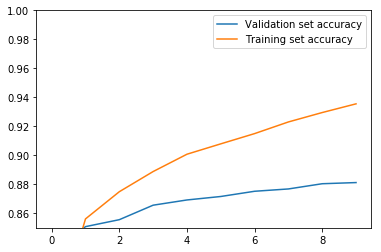

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
print("History:",hist.history["val_acc"])
print("Max accuracy:",numpy.max(hist.history["val_acc"]))
plt.ylim(0.85,1.0)
plt.plot(hist.history["val_acc"],label="Validation set accuracy")
plt.plot(hist.history["acc"],label="Training set accuracy")
plt.legend()
plt.show()

Lets make predictions for the whole training and validation data to see what type of bigrams each kernel has learnt to recognize.

In [12]:
input_data = hist.validation_data[0] # Use vectorized_data_padded if you want activations for the training data as well
predictions = cnn_out_model.predict(input_data, verbose=1, batch_size=64)
print("Predictions shape:", predictions.shape)

2500/2500 [==============================] - 1s 596us/step
Predictions shape: (2500, 2225, 50)


In [21]:
word_embeddings = model.layers[1].get_weights()[0]
print("Word embeddings from the model:", word_embeddings.shape)
print("Kernels:", model.layers[2].get_weights()[0].shape)
for kernel_index in range(model.layers[2].get_weights()[0].shape[-1]):
    kernel = model.layers[2].get_weights()[0][:,:,kernel_index]

    # Hypothetical highest activations
    activations = numpy.dot(kernel, word_embeddings.T) + model.layers[2].get_weights()[1][kernel_index] 
    best_word_indices = numpy.argmax(activations, axis=-1)
    
    # Highest activations seen in the validation data
    max_time_steps = numpy.argmax(predictions[:,:,kernel_index], axis=-1)
    max_activations = numpy.max(predictions[:,:,kernel_index], axis=-1)
    best_sentences = numpy.argsort(-max_activations)
    
    best_ngrams = [input_data[best_sentences[nth]][max_time_steps[best_sentences[nth]]:max_time_steps[best_sentences[nth]]+window_size] for nth in range(10)]
    best_ngrams = [' '.join([inversed_vocabulary[i] for i in best]) for best in best_ngrams]
    best_ngrams = ' | '.join(best_ngrams)
 
    print('Kernel %s:' % kernel_index)
    print(best_ngrams)
    print('Hypothetical maximum activation %s:' % kernel_index, ' '.join([inversed_vocabulary[wi] for wi in best_word_indices]), numpy.max(activations, axis=-1), '\n')

Word embeddings from the model: (47852, 300)
Kernels: (2, 300, 50)
Kernel 0:
heart wrenching | heart wrenching | heart change | delightful romp | delightful romp | heart gripping | superb script | Excellent movie | stunning movie | heart warmer
Hypothetical maximum activation 0: superbly romp [0.66966677 0.4546876 ] 

Kernel 1:
May 2007 | September 2007 | June 1980 | May 1934 | Jack Torrance | March 2002 | March 2005 | August 1913 | January 1991 | July 1876
Hypothetical maximum activation 1: May Bravo [0.78071016 0.6589448 ] 

Kernel 2:
incredibly unconvincing | extremely uninteresting | incredibly underwhelming | extremely lame | incredibly lame | incredibly lame | extremely forgettable | such lame | incredibly dull | equally uninteresting
Hypothetical maximum activation 2: extraordinarily unconvincing [0.55913895 0.7739633 ] 

Kernel 3:
favorite films | favorite films | favorite film | favorite film | favorite film | favorite film | favorite anime | favourite films | favourite films 

Kernel 34:
favorite film | favorite film | favorite film | favorite film | lively film | lively film | lively film | intimate movie | rare film | powerful film
Hypothetical maximum activation 34: favorites dvd [0.6831928 0.5950942] 

Kernel 35:
ludicrous Under | minutes There | minutes of | minutes of | minutes of | minutes of | minutes of | minutes of | minutes of | minutes of
Hypothetical maximum activation 35: minutes Shifting [0.8786278  0.45871338] 

Kernel 36:
Oh dear | Oh dear | Oh dear | Oh forgot | Oh wait | Oh no | Oh no | Oh no | Oh no | Oh no
Hypothetical maximum activation 36: Oh Unfortunately [1.2232612 1.0065993] 

Kernel 37:
France through | American fire | American comedy | France herein | American high | American high | American Southwest | Italy Canada | French Throughout | Japan in
Hypothetical maximum activation 37: France Irvine [0.79606336 0.46566987] 

Kernel 38:
abysmal script | poor script | poor script | poor script | poor script | poor script | lousy script 

Lets have a look at some of the kernels, e.g. kernel 10:

Worst script | incoherent script | worst acting | worst acting | worst acting | abysmal screenplay | worst written | poorly scripted | poorly filmed | poorly directed
Hypothetical maximum activation 10: worst script [1.0209291 0.7113825]

* The activating bigram seems to be a negative adjective and a movie related concept
* The hypothetical maximum activation we can generate with the given vocabulary is "worst script", which is very close to the first actual hit, however, this is not always the case:

Kernel 13:
movie sorry | movie Sorry | movie Oh | movie Oh | movie Oh | movie oh | movie oh | movie fails | movie fails | movie fails

Hypothetical maximum activation 13: porn oops [0.6134886 1.025104 ]

Sometimes the kernels are uninterpretable or they make unrealistic assumptions about the the shape of the word embedding space.

* Window size does not force the kernel to learn certain length n-grams (only sets an upper boundary):

Kernel 19:
Great soundtrack | Great film | Great film | great soundtrack | great soundtrack | Great movie | Great Movies | great film | great film | great film

Hypothetical maximum activation 19: Great worksheets [1.0821922 0.6044347]

If we look at the maximum activations for each slot in the above kernel, we notice that the first word has almost twice as high activation as the second one. This means that basically the first word has to be "great" and the second word can be almost anything, i.e. the kernel is only detecting unigrams.

* Looking at the kernel activations does not tell us anything about the kernel importance or relatedness to a certain output (e.g. positive review). To analyze these aspects of the network we have to look into the dense layers following the convolutional layer. This, however, is not straightforward as both CNN kernel activation strengths and dense layer weights should be analyzed together.